In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc03s

Data load and region parameters

In [3]:
name = 'CarR'

In [4]:
reg = 'CarR'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2'][:-1]
r = SFresults['s'][:-1]
s0 = SFresults['s0'] 
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = 2

In [7]:
sig2,r0,m,s0

(50.18670390511795, 0.5429257416905536, 0.8, 0.009293878266869804)

In [8]:
model02 = lmfit.Model(bfunc03s)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [9]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 1.5

In [10]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [11]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

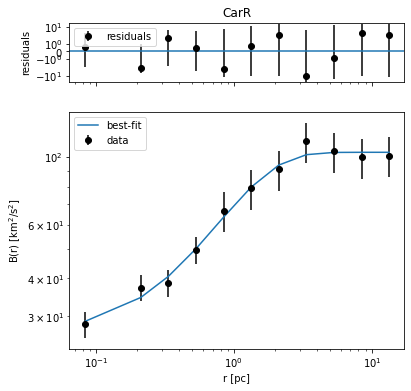

In [12]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [13]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [14]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [15]:
print(result2.fit_report())

[[Model]]
    Model(bfunc03s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 11
    # variables        = 5
    chi-square         = 1.47264625
    reduced chi-square = 0.24544104
    Akaike info crit   = -12.1191775
    Bayesian info crit = -10.1297011
[[Variables]]
    r0:     0.87940730 +/- 0.33440744 (38.03%) (init = 0.5429257)
    sig2:   38.6849139 +/- 54.3483126 (140.49%) (init = 50.1867)
    m:      1.26048574 +/- 1.09968591 (87.24%) (init = 0.8)
    s0:     0.00660729 +/- 3.48869189 (52800.69%) (init = 0.009293878)
    noise:  26.3131963 +/- 130.547079 (496.13%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  1.000
    C(sig2, noise) = -0.999
    C(sig2, s0)    = -0.999
    C(sig2, m)     = -0.989
    C(m, noise)    =  0.987
    C(m, s0)       =  0.985
    C(r0, noise)   =  0.962
    C(r0, s0)      =  0.962
    C(r0, sig2)    = -0.955
    C(r0, m)       =  0.935


In [16]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [17]:
result2.conf_interval()
print(result2.ci_report())

KeyboardInterrupt: 

plt.style.use([
    "seaborn-poster",
])

plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [ ]:
print("--- %s seconds ---" % (time.time()-start_time))